# Reconocimiento de emociones por voz para la determinación de la validez de llamadas de emergencia mediente el uso de coeficientes cepstrales de Mel

<img src="https://musicopro.com/wp-content/uploads/2019/01/mezclar-audio-profesional-grabado-en-otro-estudio-2.jpg">


El reconocimiento de las emociones humanas por medios computacionales siempre ha sido un gran desafío, esto con el fin de que la interacción humano-máquina sea lo más humana posible, la interpretación de las diferentes señales humanas que denotan una emoción tiene una gran aplicabilidad en situaciones donde se quiere obtener información del estado mental y emocional.




# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/My Drive/Proyecto-Inteligencia
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Proyecto-Inteligencia
/content/drive/My Drive/Proyecto-Inteligencia


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=23e1847c8cfc8c21d1d41b65334ca90ef187625e3a1e6a6c5b04a8f442f1e347
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [0]:
import librosa
import tensorflow as tf
from tensorflow import keras
import librosa.display
import numpy as np
from python_speech_features import mfcc
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import scipy.io.wavfile as waves
import scipy.fftpack as fourier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score


# Cargar datos

Los datos usados tienen un formato .waw, lo que implica el uso de librerias como scipy.wave_file, que permitencargar este tipo de archivos retornando el audio y adicionalmente las frecuencias de dicho audio, asunto importante para el posterior uso de los coeficientes de Mel, se guardara su localización en el array path y sus etiquetas en el array emotion.

In [0]:
emotion=[]
path = []

Para obtener los labels del data set no haviendo un archivo .csv asociado, se uso el nombre del archivo para sacar un arreglo que funcionace como label (emociones).

## CREMA dataset

In [0]:

CREMA = "data/cremad/AudioWAV/"

In [6]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [0]:
gender = []


female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)

## Datasets No Usados
Estos datasets no se usaron debido a la diferencia en los datos, duracion, etc.

### RAVDESS dataset


RAVDESS es un dataset comunmente usado debido a la calidad de los actores de voz, 24 actores de diferentes generos y con diferentes formatos de audio

In [0]:
RAV = 'data/ravdess-emotional-speech-audio/audio_speech_actors_01-24/'
dir_list = os.listdir(RAV)
dir_list.sort()

gender = []

for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)

### SAVEE dataset

Los archivos de audio en este dataset se nombran de tal manera que las letras de prefijo describen las clases de emoción de la siguiente manera:
    
    'a' = 'ira'

    'd' = 'asco'
    
    'f' = 'miedo'
    
    'h' = 'felicidad'
    
    'n' = 'neutral'
    
    'sa' = 'tristeza'
    
    'su' = 'sorpresa'

### Cargando el dataset

In [0]:
SAVEE = 'data/surrey-audiovisual-expressed-emotion-savee/ALL/'
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions

for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(SAVEE + i)
    
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)

## Permutando el path de audios y las etiquetas (emotions)

In [0]:
perm     = np.random.permutation(len(path))
path     = np.array(path)
path     = path[perm]
emotion  = np.array(emotion)
emotion  = emotion[perm]

## Guardando el path de audios y las **etiquetas**


In [0]:
np.save('path.npy', path)
np.save('emotion.npy', emotion)

# Cargando el path de audios

In [0]:
path = np.load('path.npy')
emotion = np.load('emotion.npy')


# Explorando los datos



## CREMA dataset

El dataset CREMA-D tiene 7442 datos, cada uno asociado a una emoción y genero ademas de contar con solo dos segundo de audio y ser una señal continua.

In [0]:

CREMA_df.labels.value_counts()

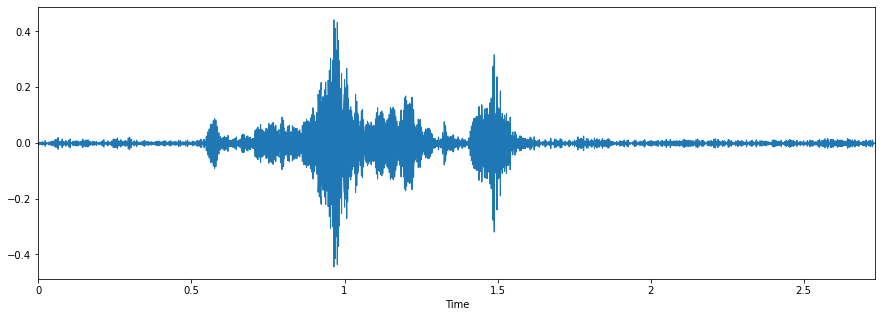

In [0]:
fname = CREMA + '1012_IEO_HAP_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

## Datasets no usados

RAVDESS dataset


In [0]:
RAV_df.labels.value_counts()

female_female_happy      87
female_female_sad        87
female_female_fear       82
female_female_angry      78
female_female_disgust    76
female_female_neutral    74
male_female_disgust      72
male_female_angry        71
male_female_fear         66
male_female_happy        61
male_female_sad          61
male_male_sad            58
male_male_disgust        58
male_male_angry          57
male_male_fear           57
male_male_happy          56
male_male_neutral        52
male_female_neutral      51
female_male_happy        42
female_male_fear         41
female_male_angry        41
female_male_sad          40
female_male_disgust      40
female_male_neutral      32
Name: labels, dtype: int64

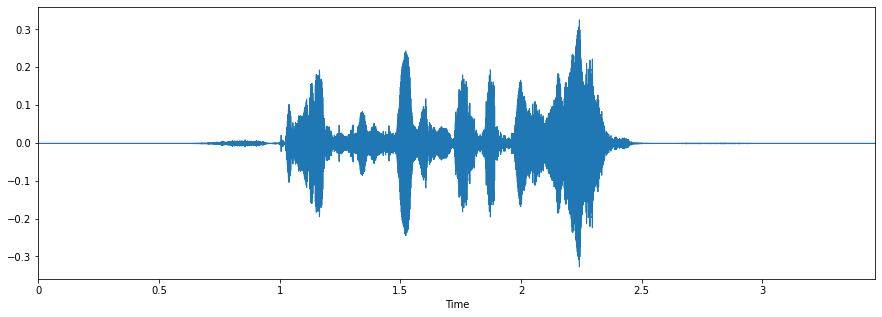

In [0]:
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# reproduciendo el audio
ipd.Audio(fname)

SAVEE dataset

In [0]:

SAVEE_df.labels.value_counts()

male_happy        731
male_angry        731
male_disgust      731
male_fear         731
male_sad          731
male_neutral      695
female_angry      600
female_disgust    600
female_happy      600
female_fear       600
female_sad        600
female_neutral    512
8                 192
7                 192
6                 192
5                 192
4                 192
3                 192
2                 192
1                  96
male_surprise      60
Name: labels, dtype: int64

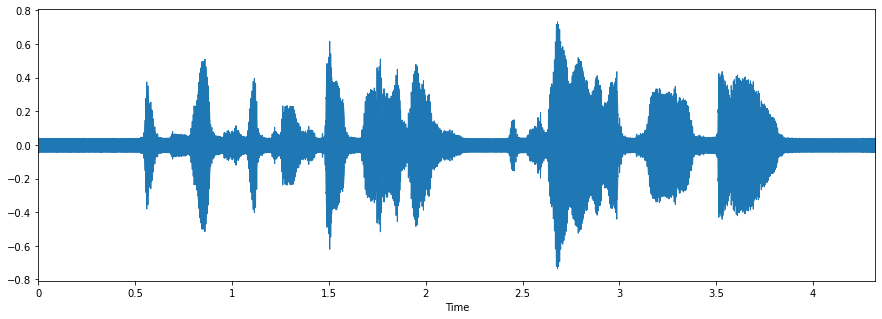

In [0]:
fname = SAVEE + 'DC_f11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# reproduciendo el audio 
ipd.Audio(fname)

# Transformada de Fourier
<img src ="https://www.nti-audio.com/portals/0/pic/news/FFT-Time-Frequency-View-540.png">


La transformada de Fourier, denominada así por Joseph Fourier, es una transformación matemática empleada para transformar señales entre el dominio del tiempo (o espacial) y el dominio de la frecuencia, que tiene muchas aplicaciones en la física y la ingeniería. Es reversible, siendo capaz de transformarse en cualquiera de los dominios al otro. El propio término se refiere tanto a la operación de transformación como a la función que produce.

En el caso de una función periódica en el tiempo (por ejemplo, un sonido musical continuo pero no necesariamente sinusoidal), la transformada de Fourier se puede simplificar para el cálculo de un conjunto discreto de amplitudes complejas, llamado coeficientes de las series de Fourier. Ellos representan el espectro de frecuencia de la señal del dominio-tiempo original.

La transformada de Fourier es una aplicación que hace corresponder a una función f con otra función g definida de la manera siguiente:

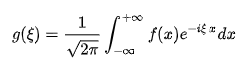


Donde L1, es decir, *f* tiene que ser una función integrable en el sentido de la integral de Lebesgue. El factor, que acompaña la integral en definición facilita el enunciado de algunos de los teoremas referentes a la transformada de Fourier. Aunque esta forma de normalizar la transformada de Fourier es la más comúnmente adoptada, no es universal. En la práctica las variables *x* y *xi*  suelen estar asociadas a dimensiones como el tiempo —segundos— y frecuencia —hercios— respectivamente, si se utiliza la fórmula alternativa:


la constante *B* cancela las dimensiones asociadas a las variables obteniendo un exponente adimensional.

La transformada de Fourier así definida goza de una serie de propiedades de continuidad que garantizan que puede extenderse a espacios de funciones mayores e incluso a espacios de funciones generalizadas.

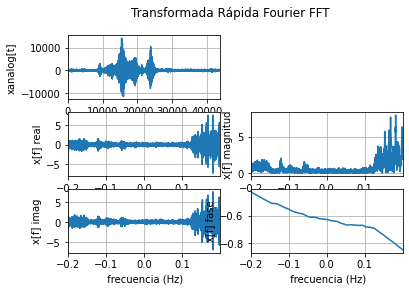

In [0]:
fsonido, sonido = waves.read(CREMA+'1012_IEO_HAP_HI.wav')
xf=fourier.fft(sonido)
xf=fourier.fftshift(xf)
# Rango de frecuencia para eje
frq=fourier.fftfreq(fsonido, 1.0)
frq=fourier.fftshift(frq)

# x[w] real
xfreal=(1/fsonido)*np.real(xf)
# x[w] imaginario
xfimag=(1/fsonido)*np.imag(xf)
# x[w] magnitud
xfabs=(1/fsonido)*np.abs(xf)
# x[w] angulo
xfangle=(1/fsonido)*np.unwrap(np.angle(xf))

plt.figure(1)       # define la grafica
plt.suptitle('Transformada Rápida Fourier FFT')

plt.subplot(321)    # grafica de 3x2, subgrafica 1
plt.ylabel('xanalog[t]')
plt.xlabel('tiempo')
plt.plot(sonido)
plt.margins(0,0.05)
plt.grid()

ventana=0.2 # ventana de frecuencia a observar alrededor f=0
ra=int(len(frq)*(0.5-ventana))
rb=int(len(frq)*(0.5+ventana))

plt.subplot(323)    # grafica de 3x2, subgrafica 3
plt.ylabel('x[f] real')
plt.xlabel(' frecuencia (Hz)')
plt.plot(frq[ra:rb],xfreal[ra:rb])
plt.margins(0,0.05)
plt.grid()

plt.subplot(325)    # grafica de 3x2, subgrafica 5
plt.ylabel('x[f] imag')
plt.xlabel(' frecuencia (Hz)')
plt.plot(frq[ra:rb],xfimag[ra:rb])
plt.margins(0,0.05)
plt.grid()

plt.subplot(324)    # grafica de 3x2, subgrafica 4
plt.ylabel('x[f] magnitud')
plt.xlabel(' frecuencia (Hz)')
plt.plot(frq[ra:rb],xfabs[ra:rb])
plt.margins(0,0.05)
plt.grid()

plt.subplot(326)    # grafica de 3x2, subgrafica 6
plt.ylabel('x[f] fase')
plt.xlabel(' frecuencia (Hz)')
plt.plot(frq[ra:rb],xfangle[ra:rb])
plt.margins(0,0.05)
plt.grid()

plt.show()

# Coeficientes cepstrales de Mel en frecuencia Mel MFCC

Coeﬁcientes para la representación del habla basados en la percepción auditiva humana. Estos surgen de la necesidad, en el área del reconocimiento de audio automático, de extraer características de las componentes de una señal de audio que sean adecuadas para la identificación de contenido relevante, así como obviar todas aquellas que posean información poco valiosa como el ruido de fondo, emociones, volumen, tono, etc. y que no aportan nada al proceso de reconocimiento, al contrario lo empobrecen.

Los MFCCs son una característica ampliamente usada en el reconocimiento automático del discurso o el locutor y fueron introducidos por Davis y Mermelstein en los años 80 y han sido el estado del arte desde entonces.

MFCCs se calculan comúnmente de la siguiente forma:

1.   Separar la señal en pequeños tramos.
2.   A cada tramo aplicarle la Transformada de Fourier discreta y obtener la potencia espectral de la señal.
3.   Aplicar el banco de filtros correspondientes a la Escala Mel al espectro obtenido en el paso anterior y sumar las energías en cada uno de ellos.
4.   Tomar el logaritmo de todas las energías de cada frecuencia mel
Aplicarle la transformada de coseno discreta a estos logaritmos.


Estos valores obtenidos son los coeficientes que buscamos. Aunque opcionalmente se le pueden añadir otros valores como los deltas y/o los delta-deltas.

<class 'numpy.ndarray'>


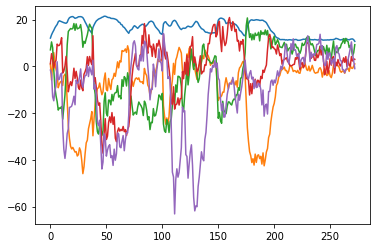

In [0]:
print (type(fsonido))
fsonido, sonido = librosa.load(path[202])
mfcc_1 = mfcc(sonido,fsonido, numcep=5)
plt.subplot
plt.plot(mfcc_1)
# plt.plot(sonido)
# print (mfcc_1[:,2])


# Calculo MFCC con 1, 5 y 13 coeficientes cepstrales


In [16]:
print(path.shape)

(7442,)


In [0]:

MelCoS5 =[]
MelCoS13 =[]
for i in path:
  #parametros adicionales el el librosa.load para agilizar el proceso de carga, seleccionar el fragmento y fijar caracteristicas para todos lo audios
  frequencie,audio, = waves.read(i)
  MelCoS5.append(mfcc(audio, frequencie,  numcep=5))
  MelCoS13.append(mfcc(audio, frequencie, numcep=13))

# Escalar los diferentes MFCC a un tamaño unico

In [0]:
def normalize (Mel):
  max = 256
  array=[]
  for item in Mel:
    if (item.shape[0]<max):
      x = np.zeros(((max- item.shape[0]),item.shape[1]))
      item= np.concatenate((item,x) , axis =0)
    else:
      item = item[0:max, :]

    array.append(item)
  return array

In [0]:
Mel_13= np.array(normalize(MelCoS13))
Mel_5= np.array(normalize(MelCoS5))


In [0]:


Mel5  = np.array(Mel_5)
Mel13 = np.array(Mel_13)


np.save('Mel_13.npy', Mel_13)

np.save('Mel_5.npy', Mel_5)

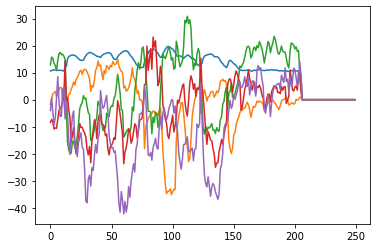

In [0]:
plt.plot(Mel_5[7000])

# Carga de los MFCC con diferentes coeficientes Cepstrales

In [0]:

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


In [0]:
Mel__5= np.load('Mel_5.npy')
Mel__13=np.load('Mel_13.npy')
# restore np.load for future normal usage
np.load = np_load_old

# Conversion a enteros de las caracteristicas
Problemas con la red neurnal, error de la misma al tratar de convertir a flotante las etiquetas.

In [8]:
emotionLabel = np.unique(emotion)
print(emotionLabel)

['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'male_angry' 'male_disgust' 'male_fear'
 'male_happy' 'male_neutral' 'male_sad']


In [0]:
emotionIntLabel =[]
for item in emotion:
  labeltemp=0
  for i in range(len(emotionLabel)):
    if(item==emotionLabel[i]):
      labeltemp=i
  emotionIntLabel.append(labeltemp)


In [10]:
n=7440
print(emotion[n],emotionIntLabel[n])

male_neutral 10


# MFCC con 13 (valor por defecto) coeficientes cepstrales- sin convoluciones

In [50]:
model = keras.models.Sequential([
    keras.layers.Flatten( input_shape=[256,13]),
    keras.layers.Dense(2048, activation=tf.nn.relu),
    keras.layers.Dense(1024, activation=tf.nn.relu),
    keras.layers.Dense(512, activation=tf.nn.selu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(12, activation=tf.nn.softmax)
])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 3328)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 2048)              6817792   
_________________________________________________________________
dense_41 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_42 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_43 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_44 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_45 (Dense)             (None, 12)              

In [0]:
model.compile(optimizer=tf.train.AdagradOptimizer(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(Mel__13, emotionIntLabel, test_size=0.2)

In [57]:
history=model.fit(X_train, y_train,batch_size=64 ,epochs=15, verbose=1,  validation_data=(X_test,y_test))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 5953 samples, validate on 1489 samples
Epoch 1/15
5953/5953 [==============================] - 1s 143us/sample - loss: 0.6905 - acc: 0.8355 - val_loss: 0.6457 - val_acc: 0.8455
Epoch 2/15
5953/5953 [==============================] - 1s 92us/sample - loss: 0.5734 - acc: 0.8576 - val_loss: 0.5824 - val_acc: 0.8670
Epoch 3/15
5953/5953 [==============================] - 1s 91us/sample - loss: 0.5166 - acc: 0.8681 - val_loss: 0.5689 - val_acc: 0.8664
Epoch 4/15
5953/5953 [==============================] - 1s 92us/sample - loss: 0.4825 - acc: 0.8759 - val_loss: 0.5558 - val_acc: 0.8717
Epoch 5/15
5953/5953 [==============================] - 1s 91us/sample - loss: 0.4548 - acc: 0.8836 - val_loss: 0.5971 - val_acc: 0.8509
Epoch 6/15
5953/5953 [==============================] - 1s 92us/sample - loss: 0.4389 - acc: 0.8866 - val_loss: 0.6038 - val_acc: 0.8509
Epoch 7/15


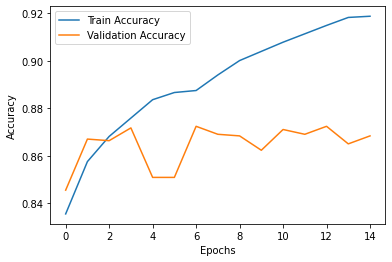

In [58]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# MFFC con 13 coeficientes cepstrales usando convoluciones

In [0]:
X_train, X_test, y_train, y_test = train_test_split(Mel__13, emotionIntLabel, test_size=0.1)

In [0]:
X_train= np.expand_dims(X_train,axis=3)

In [18]:
X_train[0].shape

(256, 13, 1)

In [0]:
X_test= np.expand_dims(X_test,axis=3)

In [0]:
model_CNN =  keras.models.Sequential()
model_CNN.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(256,13, 1)))
model_CNN.add(keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# model_CNN.add(keras.layers.Dropout(0.25))
model_CNN.add(keras.layers.MaxPooling2D((2, 2)))
model_CNN.add(keras.layers.Flatten())
# model_CNN.add(keras.layers.Dropout(0.25))
model_CNN.add(keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'))
model_CNN.add(keras.layers.Dense(12, activation='softmax'))
opt = keras.optimizers.SGD(lr=0.005, momentum=0.9)
model_CNN.compile(optimizer=tf.train.FtrlOptimizer(learning_rate=0.001), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [71]:
history=model_CNN.fit(X_train, y_train,batch_size=64 ,epochs=20, verbose=1,  validation_data=(X_test,y_test))

Train on 6697 samples, validate on 745 samples
Epoch 1/20
6697/6697 [==============================] - 1s 219us/sample - loss: 3.2431 - acc: 0.1251 - val_loss: 2.4462 - val_acc: 0.1396
Epoch 2/20
6697/6697 [==============================] - 1s 168us/sample - loss: 2.3860 - acc: 0.1631 - val_loss: 2.3879 - val_acc: 0.1678
Epoch 3/20
6697/6697 [==============================] - 1s 166us/sample - loss: 2.3323 - acc: 0.1922 - val_loss: 2.3522 - val_acc: 0.1919
Epoch 4/20
6697/6697 [==============================] - 1s 166us/sample - loss: 2.2841 - acc: 0.2132 - val_loss: 2.3144 - val_acc: 0.1987
Epoch 5/20
6697/6697 [==============================] - 1s 165us/sample - loss: 2.2348 - acc: 0.2340 - val_loss: 2.2833 - val_acc: 0.2040
Epoch 6/20
6697/6697 [==============================] - 1s 160us/sample - loss: 2.1904 - acc: 0.2473 - val_loss: 2.2400 - val_acc: 0.2430
Epoch 7/20
6697/6697 [==============================] - 1s 159us/sample - loss: 2.1400 - acc: 0.2747 - val_loss: 2.2336 - val

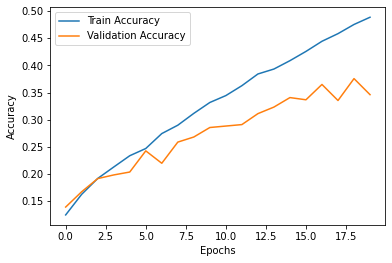

In [72]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Machine Learning



In [0]:
from sklearn.metrics import *
from sklearn.model_selection import KFold

In [0]:

est = SVC(kernel='linear', C= 50)
s = cross_val_score(est, X_train, y_train, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))